Some imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

Limits are mentioned to get a 1000x1000 portion of the whole image -- Probably wrong approach

In [2]:
lower_base = 1500
upper_base = 2500

top_limit = 2640
bottom_limit = 3640
#in meters
screenwidth = 525
screenheight = 300
distance = 160 #16cm

In [3]:
datafb = pd.read_csv('filtered_full_brightness1.csv', header=None)
datalr = pd.read_csv('filtered_left_right_gradient1.csv', header=None)
datatb = pd.read_csv('filtered_top_bottom_gradient1.csv', header=None)

datafb = 255 * (datafb - np.min(datafb)) / (np.max(datafb) - np.min(datafb))
datalr = 255 * (datalr - np.min(datalr)) / (np.max(datalr) - np.min(datalr))
datatb = 255 * (datatb - np.min(datatb)) / (np.max(datatb) - np.min(datatb))

full_brightness = datafb.iloc[top_limit:bottom_limit, lower_base:upper_base]
left_right = datalr.iloc[top_limit:bottom_limit, lower_base:upper_base]
bottom_top = datatb.iloc[top_limit:bottom_limit, lower_base:upper_base]

From Giellinger Paper

In [ ]:
Rx = left_right / full_brightness
Ry = bottom_top / full_brightness
R1 = (screenwidth / (screenwidth**2 + distance**2)) * (2*Rx - 1)
R2 = (screenheight / (screenheight**2 + distance**2)) * (2*Ry - 1)
R3 = np.sqrt(1 - R1**2 - R2**2)
#v = np.array([1, 0, 0])
v = np.array([0, 0, 1])
r_vector = np.stack([R1,R2,R3], axis=-1)
normal_vector = (r_vector + v)
normal_vector /= np.linalg.norm(normal_vector, keepdims=True)

In [ ]:
#to help with visualization
normal_vector5 = normal_vector * 10e5
normal_vector6 = normal_vector5
print(normal_vector.shape)
plt.figure(figsize=(12, 6))
plt.imshow(normal_vector6, cmap='colorwarm') 
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_normal_map(image_path):
    # Open the image using Pillow
    image = Image.open(image_path)

    # Convert the image to a NumPy array
    normal_map = np.array(image)

    return normal_map

# Example usage
image_path = "NormalMap.png"
normal_map = load_normal_map(image_path)

# Check the shape of the normal map
print("Normal Map shape:", normal_map.shape)
plt.figure(figsize=(8, 8))
plt.imshow(normal_map, cmap='coolwarm')  # 'coolwarm' colormap shows blue to red range
plt.axis('off')  # Hide axes for better visualization
plt.title('Normal Map Visualization')
plt.show()

Normal Map shape: (512, 512, 4)


In [30]:
normal_vector = normal_map[:, :, :3]

This method - Start with corner(0,0) as 0 height. Adding gradients from x and y to determine the height

Lowest point (height): 0.0
Highest point (height): 461.2343477739828


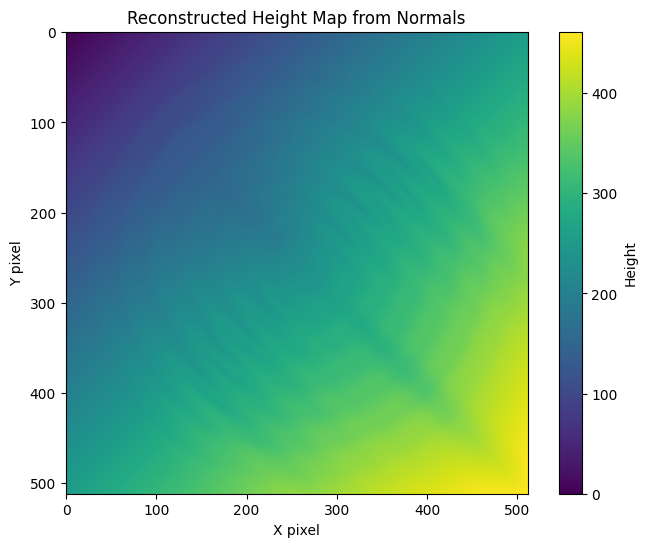

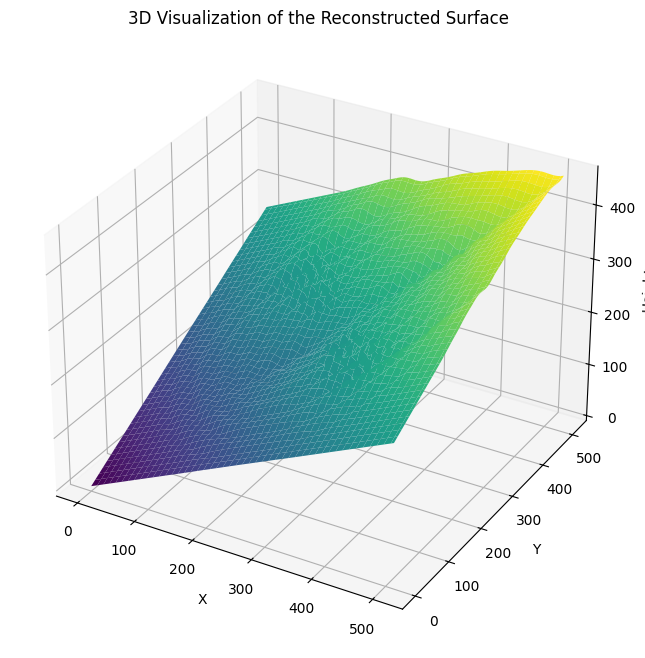

In [31]:
def integrate_normals(normals):
    H, W, _ = normals.shape
    n_x = normals[:, :, 0]
    n_y = normals[:, :, 1]
    n_z = normals[:, :, 2]
    g_x = - n_x / n_z 
    g_y = - n_y / n_z  

    height_map = np.zeros((H, W))

    #along first row
    for j in range(1, W):
        height_map[0, j] = height_map[0, j-1] + g_x[0, j-1]

    #along first column
    for i in range(1, H):
        height_map[i, 0] = height_map[i-1, 0] + g_y[i-1, 0]

    #  averaging two directions
    for i in range(1, H):
        for j in range(1, W):
            h_from_left = height_map[i, j-1] + g_x[i, j-1]
            h_from_top  = height_map[i-1, j] + g_y[i-1, j]
            height_map[i, j] = (h_from_left + h_from_top) / 2.0

    return height_map

# Integrate the normals to get the height map
height_map = integrate_normals(normal_vector)

# Find the lowest and highest points
min_height = np.min(height_map)
max_height = np.max(height_map)
print("Lowest point (height):", min_height)
print("Highest point (height):", max_height)

# ----- Visualization -----
plt.figure(figsize=(8, 6))
plt.imshow(height_map, cmap='viridis')
plt.title("Reconstructed Height Map from Normals")
plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.colorbar(label="Height")
plt.show()

# Optionally, plot an interactive 3D surface (using matplotlib)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(512), np.arange(512))
ax.plot_surface(X, Y, height_map, cmap='viridis', edgecolor='none')
ax.set_title("3D Visualization of the Reconstructed Surface")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Height")
plt.show()


In [32]:
import plotly.graph_objects as go

# Downsample the height map for smoother visualization
downsample_factor = 20
z_sampled = height_map[::downsample_factor, ::downsample_factor]

# Create interactive 3D plot
fig = go.Figure(data=[go.Surface(z=z_sampled)])
fig.update_layout(
    title='3D Height Map',
    scene=dict(
        zaxis=dict(title='Height'),
        xaxis=dict(title='X'),
        yaxis=dict(title='Y')
    )
)
fig.show()

Height Map reconstruction using FFT Solver

Lowest Point: -3204.358943507961, Highest Point: 321.14448487274854


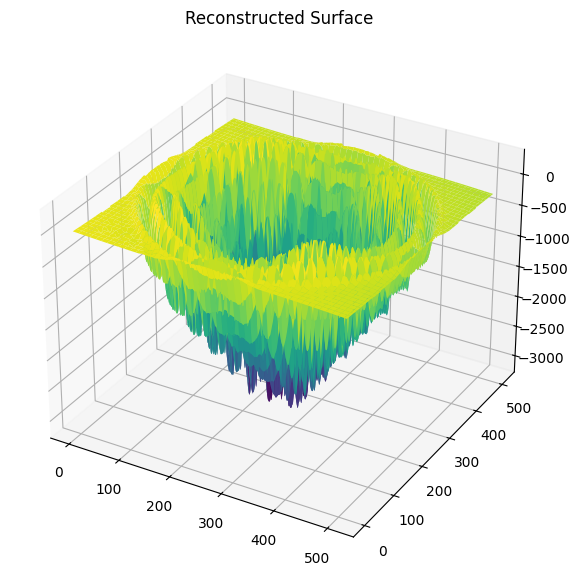

In [33]:
import scipy.fftpack
from mpl_toolkits.mplot3d import Axes3D

def poisson_solver_fft(g_x, g_y):
    """ Solve Poisson's equation to reconstruct the height map. """
    height, width = g_x.shape
    f = np.zeros((height, width))

    # Compute divergence of the gradient field
    f[:, :-1] += g_x[:, :-1]  
    f[:, 1:]  -= g_x[:, :-1]  
    f[:-1, :] += g_y[:-1, :]  
    f[1:, :]  -= g_y[:-1, :]  

    # Compute DFT (Fourier Transform)
    f_hat = scipy.fftpack.fft2(f)
    
    # Create frequency meshgrid
    kx = np.fft.fftfreq(width).reshape(1, -1)
    ky = np.fft.fftfreq(height).reshape(-1, 1)
    
    # Poisson equation denominator
    denom = (4 - 2 * np.cos(2 * np.pi * kx) - 2 * np.cos(2 * np.pi * ky))
    denom[0, 0] = 1  # Avoid division by zero

    # Solve in frequency domain
    Z_hat = f_hat / denom
    Z_hat[0, 0] = 0  # Set reference height to zero

    # Inverse Fourier Transform to get height map
    Z = np.real(scipy.fftpack.ifft2(Z_hat))

    return Z

# Simulated gradient field (Replace with real data)
g_x = normal_vector[:, :, 0]  # Gradient in x direction  
g_y = normal_vector[:, :, 1]  # Gradient in y direction

# Compute height map
height_map = poisson_solver_fft(g_x, g_y)

# Set reference point Z(0,0) = 0
height_map -= height_map[0, 0]

# Find highest and lowest points
min_height = np.min(height_map)
max_height = np.max(height_map)
print(f"Lowest Point: {min_height}, Highest Point: {max_height}")

# Visualization (Matplotlib 3D Plot)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Generate grid
X, Y = np.meshgrid(np.arange(512), np.arange(512))

# Plot surface
ax.plot_surface(X, Y, height_map, cmap='viridis', edgecolor='none')
ax.set_title("Reconstructed Surface")
plt.show()

Height Map reconstruction using DCT and IDCT

In [34]:
from scipy.fftpack import dct, idct

def dct2(x):
    return dct(dct(x, axis=0, norm='ortho'), axis=1, norm='ortho')

def idct2(x):
    return idct(idct(x, axis=0, norm='ortho'), axis=1, norm='ortho')

def solve_poisson(divergence):
    m, n = divergence.shape
    f_dct = dct2(divergence)
    
    # Compute eigenvalues for the DCT-based Poisson solver
    i, j = np.ogrid[0:m, 0:n]
    denom = 2 * (np.cos(np.pi * i/m) - 1) + 2 * (np.cos(np.pi * j/n) - 1)
    denom[0, 0] = 1  # Avoid division by zero
    
    f_dct /= denom
    f_dct[0, 0] = 0  # Set DC component to zero (arbitrary constant)
    
    z = idct2(f_dct)
    return z

# Assuming your gradient is stored in a variable `gradient` of shape (1000, 1000, 3)
# If gradient contains surface normals (nx, ny, nz):
nx = normal_vector[:, :, 0]
ny = normal_vector[:, :, 1]
nz = normal_vector[:, :, 2]
p = -nx / (nz + 1e-3)  # Avoid division by zero
q = -ny / (nz + 1e-3)

# Compute divergence of the (p, q) field
dpx = np.gradient(p, axis=1)  # Derivative of p w.r.t x (columns)
dqy = np.gradient(q, axis=0)  # Derivative of q w.r.t y (rows)
divergence = dpx + dqy

# Solve Poisson equation
height_map = solve_poisson(divergence)

In [35]:
# Find min and max heights
min_height = np.min(height_map)
max_height = np.max(height_map)

# Find their positions
min_pos = np.unravel_index(np.argmin(height_map), height_map.shape)
max_pos = np.unravel_index(np.argmax(height_map), height_map.shape)

print(f"Deepest point: Height = {min_height}, Position = {min_pos}")
print(f"Highest point: Height = {max_height}, Position = {max_pos}")

Deepest point: Height = -14.179894264413507, Position = (np.int64(208), np.int64(208))
Highest point: Height = 12.139088068363725, Position = (np.int64(97), np.int64(350))


In [36]:
import plotly.graph_objects as go

# Downsample the height map for smoother visualization
downsample_factor = 20
z_sampled = height_map[::downsample_factor, ::downsample_factor]

# Create interactive 3D plot
fig = go.Figure(data=[go.Surface(z=z_sampled)])
fig.update_layout(
    title='3D Height Map',
    scene=dict(
        zaxis=dict(title='Height'),
        xaxis=dict(title='X'),
        yaxis=dict(title='Y')
    )
)
fig.show()

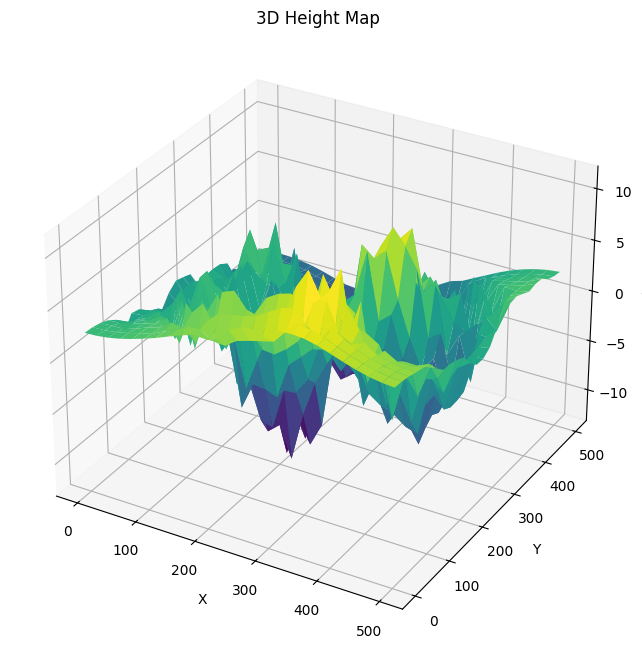

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Downsample data
stride = 20
x = np.arange(0, height_map.shape[1], stride)
y = np.arange(0, height_map.shape[0], stride)
X, Y = np.meshgrid(x, y)
Z = height_map[::stride, ::stride]

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')
plt.title('3D Height Map')
plt.show()

Unverified GPT solver using FFT and Neumann boundary condition

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import sparse
from scipy.sparse.linalg import spsolve
import plotly.graph_objects as go

def integrate_gradient_field(gx, gy, boundary_condition='neumann'):
    """
    Reconstruct height map from gradient fields using Poisson equation.
    Uses sparse matrices for efficient computation.
    
    Parameters:
    gx, gy : 2D arrays representing x and y gradients
    boundary_condition : 'neumann' (default) or 'dirichlet'
    
    Returns:
    z : reconstructed height map
    """
    h, w = gx.shape
    n = h * w
    
    # Construct the A matrix for sparse linear system
    # We'll build it using coordinate format
    i_indices = []
    j_indices = []
    values = []
    
    # Construct right-hand side of equation
    b = np.zeros(n)
    
    # For each pixel (i,j)
    for i in range(h):
        for j in range(w):
            index = i * w + j
            
            # Each pixel contributes to the system
            if boundary_condition == 'dirichlet' and (i == 0 or i == h-1 or j == 0 or j == w-1):
                # Boundary condition: fixed value (=0)
                i_indices.append(index)
                j_indices.append(index)
                values.append(1.0)
                b[index] = 0
            else:
                # Count neighbors first
                count = 0
                
                # Check all 4 neighbors (with bounds checking)
                # Left neighbor
                if j > 0:
                    i_indices.append(index)
                    j_indices.append(index - 1)
                    values.append(-1.0)
                    count += 1
                    b[index] -= gx[i, j-1]  # Gradient contribution
                
                # Right neighbor
                if j < w - 1:
                    i_indices.append(index)
                    j_indices.append(index + 1)
                    values.append(-1.0)
                    count += 1
                    b[index] += gx[i, j]  # Gradient contribution
                
                # Upper neighbor
                if i > 0:
                    i_indices.append(index)
                    j_indices.append(index - w)
                    values.append(-1.0)
                    count += 1
                    b[index] -= gy[i-1, j]  # Gradient contribution
                
                # Lower neighbor
                if i < h - 1:
                    i_indices.append(index)
                    j_indices.append(index + w)
                    values.append(-1.0)
                    count += 1
                    b[index] += gy[i, j]  # Gradient contribution
                
                # Add central pixel with the correct coefficient
                if count > 0:
                    i_indices.append(index)
                    j_indices.append(index)
                    values.append(float(count))
    
    # Create sparse matrix
    A = sparse.coo_matrix((values, (i_indices, j_indices)), shape=(n, n)).tocsr()
    
    # Solve the system
    x = spsolve(A, b)
    
    # Reshape the result to the image dimensions
    z = x.reshape((h, w))
    
    return z

def analyze_surface(height_map):
    """
    Analyze the surface to find its characteristics.
    
    Parameters:
    height_map : 2D array representing the reconstructed height
    
    Returns:
    dict : containing min and max points information
    """
    min_height = np.min(height_map)
    max_height = np.max(height_map)
    
    # Find coordinates of min/max points
    min_loc = np.unravel_index(np.argmin(height_map), height_map.shape)
    max_loc = np.unravel_index(np.argmax(height_map), height_map.shape)
    
    return {
        'min_height': min_height,
        'min_location': min_loc,
        'max_height': max_height,
        'max_location': max_loc,
        'height_range': max_height - min_height
    }

def visualize_surface_matplotlib(height_map):
    """
    Create a 3D visualization of the surface using Matplotlib.
    
    Parameters:
    height_map : 2D array representing the reconstructed height
    """
    h, w = height_map.shape
    x = np.arange(0, w, 1)
    y = np.arange(0, h, 1)
    X, Y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, height_map, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Height')
    ax.set_title('Reconstructed Surface')
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

def visualize_surface_plotly(height_map):
    """
    Create an interactive 3D visualization of the surface using Plotly.
    This provides pan, zoom, and rotation capabilities.
    
    Parameters:
    height_map : 2D array representing the reconstructed height
    """
    h, w = height_map.shape
    y, x = np.mgrid[:h, :w]
    
    # Create the 3D surface plot
    fig = go.Figure(data=[go.Surface(z=height_map, x=x, y=y)])
    
    fig.update_layout(
        title='Interactive 3D Surface Reconstruction',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Height',
            aspectratio=dict(x=1, y=1, z=0.5)
        ),
        width=900,
        height=700,
    )
    
    # Find min and max points
    stats = analyze_surface(height_map)
    min_loc = stats['min_location']
    max_loc = stats['max_location']
    
    # Add markers for min and max points
    fig.add_trace(go.Scatter3d(
        x=[min_loc[1]], 
        y=[min_loc[0]], 
        z=[stats['min_height']],
        mode='markers',
        marker=dict(size=8, color='blue'),
        name=f"Lowest Point: {stats['min_height']:.2f}"
    ))
    
    fig.add_trace(go.Scatter3d(
        x=[max_loc[1]], 
        y=[max_loc[0]], 
        z=[stats['max_height']],
        mode='markers',
        marker=dict(size=8, color='red'),
        name=f"Highest Point: {stats['max_height']:.2f}"
    ))
    
    fig.show()

In [39]:
gx = normal_vector[:, :, 0]  # x-gradient
gy = normal_vector[:, :, 1]

In [40]:
height_map = integrate_gradient_field(gx, gy)
stats = analyze_surface(height_map)
    
print("\nSurface Analysis Results:")
print(f"Deepest point: {stats['min_height']:.4f} at position {stats['min_location']}")
print(f"Highest point: {stats['max_height']:.4f} at position {stats['max_location']}")
print(f"Height range: {stats['height_range']:.4f}")


Surface Analysis Results:
Deepest point: 238664.0740 at position (np.int64(511), np.int64(511))
Highest point: 369058.2853 at position (np.int64(0), np.int64(0))
Height range: 130394.2113


In [41]:
visualize_surface_plotly(height_map)

Unverified GPT generated code of the paper used in Giellinger Paper

In [46]:
from scipy.sparse import lil_matrix, coo_matrix
from scipy.sparse.linalg import lsqr

def basis_function(t):
    """Quadratic B-spline basis functions and their derivatives evaluated at t in [0, 2]."""
    N0 = 0.5 - t/2 + t**2 / 8
    N1 = 0.5 + t/2 - t**2 / 4
    N2 = t**2 / 8
    dN0 = -0.5 + t/4
    dN1 = 0.5 - t/2
    dN2 = t/4
    return [N0, N1, N2], [dN0, dN1, dN2]

def reconstruct_height_map(normal_map, boundary_value=0.0, lambda_fair=0.0):
    M, N, _ = normal_map.shape
    assert M % 2 == 0 and N % 2 == 0, "M and N must be even"
    
    # Control points grid dimensions
    ctrl_M = (M // 2) + 2
    ctrl_N = (N // 2) + 2
    num_ctrl = ctrl_M * ctrl_N
    
    # Precompute basis functions for possible s and t values (0.5, 1.5)
    s_values = [0.5, 1.5]
    basis_cache = {}
    for s in s_values:
        Ns, dNs = basis_function(s)
        basis_cache[s] = (Ns, dNs)
    
    # Initialize sparse matrix and rhs
    num_pixels = M * N
    num_equations = 2 * num_pixels + 1  # +1 for boundary condition
    A = lil_matrix((num_equations, num_ctrl))
    b = np.zeros(num_equations)
    
    row = 0
    for x in range(M):
        for y in range(N):
            u = x + 0.5
            v = y + 0.5
            i_patch = int(u // 2)
            j_patch = int(v // 2)
            s = u - 2 * i_patch
            t = v - 2 * j_patch
            
            # Get precomputed basis functions
            Ns, dNs = basis_cache[s]
            Nt, dNt = basis_cache[t]
            
            # Get normal
            nx, ny, nz = normal_map[x, y]
            if np.abs(nz) < 1e-6:
                nz = 1e-6  # Avoid division by zero
            hu = -nx / nz
            hv = -ny / nz
            
            # Populate h_u equation
            for i in range(3):
                for j in range(3):
                    coeff = dNs[i] * Nt[j]
                    ctrl_k = i_patch + i
                    ctrl_l = j_patch + j
                    if 0 <= ctrl_k < ctrl_M and 0 <= ctrl_l < ctrl_N:
                        col = ctrl_k * ctrl_N + ctrl_l
                        A[row, col] += coeff
            b[row] = hu
            row += 1
            
            # Populate h_v equation
            for i in range(3):
                for j in range(3):
                    coeff = Ns[i] * dNt[j]
                    ctrl_k = i_patch + i
                    ctrl_l = j_patch + j
                    if 0 <= ctrl_k < ctrl_M and 0 <= ctrl_l < ctrl_N:
                        col = ctrl_k * ctrl_N + ctrl_l
                        A[row, col] += coeff
            b[row] = hv
            row += 1
    
    # Boundary condition: h(0,0) = boundary_value (sum of 4 control points /4 = boundary_value)
    ctrl_00 = [0, 0], [0, 1], [1, 0], [1, 1]
    for (k, l) in ctrl_00:
        if k < ctrl_M and l < ctrl_N:
            col = k * ctrl_N + l
            A[row, col] = 0.25
    b[row] = boundary_value
    row += 1
    
    # Convert to COO format for efficient solving
    A = A.tocoo()
    
    # Solve least squares
    result = lsqr(A, b, damp=lambda_fair)
    ctrl_heights = result[0].reshape((ctrl_M, ctrl_N))
    
    # Reconstruct height map
    height_map = np.zeros((M, N))
    for x in range(M):
        for y in range(N):
            u = x + 0.5
            v = y + 0.5
            i_patch = int(u // 2)
            j_patch = int(v // 2)
            s = u - 2 * i_patch
            t = v - 2 * j_patch
            
            Ns, _ = basis_cache[s]
            Nt, _ = basis_cache[t]
            
            z = 0.0
            for i in range(3):
                for j in range(3):
                    ctrl_k = i_patch + i
                    ctrl_l = j_patch + j
                    if 0 <= ctrl_k < ctrl_M and 0 <= ctrl_l < ctrl_N:
                        z += ctrl_heights[ctrl_k, ctrl_l] * Ns[i] * Nt[j]
            height_map[x, y] = z
    
    return height_map, ctrl_heights

# Example usage:
# normal_map = np.load('normal_map.npy')  # Shape (M, N, 3)
# height_map, ctrl_heights = reconstruct_height_map(normal_map)

In [ ]:
height_map, ctrl_heights = reconstruct_height_map(normal_vector)
import plotly.graph_objects as go

def plot_3d_plotly(height_map):
    M, N = height_map.shape
    X, Y = np.meshgrid(np.arange(N), np.arange(M))  # Swap axes for correct orientation
    Z = height_map

    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])
    fig.update_layout(
        title='Interactive 3D Height Map',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        autosize=False,
        width=1000,
        height=800,
    )
    fig.show()

# Example usage:
plot_3d_plotly(height_map)

C:\Users\bhara\AppData\Local\Temp\ipykernel_10208\2940397191.py:54: RuntimeWarning:

overflow encountered in scalar negative

C:\Users\bhara\AppData\Local\Temp\ipykernel_10208\2940397191.py:55: RuntimeWarning:

overflow encountered in scalar negative



In [ ]:
print("Shape of normal_map:", normal_vector.shape)

Shape of normal_map: (512, 512, 4)
